# Introduction - Dalio's Uncorrelated Returns Portfolio Management Research

This notebook explores Ray Dalio's concept of uncorrelated returns for portfolio management.

## Objectives

1. Understand the concept of uncorrelated returns
2. Analyze correlation between different asset classes
3. Construct portfolios using uncorrelated return streams
4. Evaluate risk-adjusted performance
5. Implement practical portfolio management strategies

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import yfinance as yf
import riskfolio as rp

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Analysis started: 2026-01-28 11:22:37


In this first practical step, we start by selecting a small universe of liquid, well-known assets across different asset classes (equities, tech mega-caps, gold, and major cryptocurrencies). The goal is to visually and quantitatively inspect how these assets co-move and whether they provide useful diversification benefits.

Later on, we will automate this process to systematically pick the best 10–15 assets (e.g., from a larger universe of highly traded instruments) based on volume/liquidity and other filters, but for now we keep the universe intentionally simple so we can build intuition.

We will fetch historical price data and focus specifically on the `Adj Close` (Adjusted Close) column for each asset. Adjusted Close accounts for dividends, stock splits, and other corporate actions that affect the effective return to an investor, making it the right series to use for return calculations and portfolio analysis.

In [9]:
assets = [
    "GLD",
    "BTC-USD",
    "ETH-USD",
    "AAPL",
    "MSFT",
    "AMZN",
    "TSLA",
    "NVDA",
    "GOOG",
    "META"
]

csv_path = "data/initial.csv"

if os.path.exists(csv_path):
    # Load previously downloaded data
    data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
else:
    # Fetch data from API, keep only Adj Close, and save to CSV
    data = yf.download(assets, start="2020-01-01", end="2026-01-01", auto_adjust=False)
    data = data.loc[:, "Adj Close"]

    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    data.to_csv(csv_path)

data

,AAPL,AMZN,BTC-USD,ETH-USD,GLD,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-01-01,NaN,NaN,7200.174316,130.802002,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,72.468262,94.900497,6985.470215,127.410179,143.949997,67.859543,208.324768,152.505661,5.971077,28.684000
2020-01-03,71.763718,93.748497,7344.884277,134.171707,145.860001,67.526535,207.222488,150.606750,5.875507,29.534000
2020-01-04,NaN,NaN,7410.656738,135.069366,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,7411.317383,136.276779,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-12-27,NaN,NaN,87802.156250,2947.998291,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-28,NaN,NaN,87835.835938,2948.568115,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-29,273.760010,232.070007,87138.140625,2934.538330,398.600006,314.390015,658.690002,487.100006,188.220001,459.640015


Now that we have the daily price data for each asset, the next step is to convert these prices into **percentage returns**. Portfolio construction and risk analysis are almost always done on returns, not on raw prices, because:

- Returns are **scale-invariant** and directly comparable across assets with very different price levels (e.g., BTC vs. AAPL).
- Correlations and other dependency measures are defined in terms of return co-movements.
- Risk metrics such as volatility, drawdowns, and Sharpe ratios are computed from return series.

We therefore compute **daily percentage returns** using `pct_change()` and drop the initial `NaN` rows that result from the first difference.

In [10]:
returns = data.pct_change().dropna()
returns

/var/folders/jn/y5sznyds3jn3gnk2zpy70gj80000gn/T/ipykernel_92634/2547544665.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


,AAPL,AMZN,BTC-USD,ETH-USD,GLD,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-01-03,-0.009722,-0.012139,0.051452,0.053069,0.013269,-0.004907,-0.005291,-0.012451,-0.016006,0.029633
2020-01-04,0.000000,0.000000,0.008955,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000089,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.007968,0.014886,0.048291,0.058905,0.010490,0.024657,0.018834,0.002584,0.004193,0.019255
2020-01-07,-0.004703,0.002092,0.050774,-0.005268,0.003935,-0.000624,0.002164,-0.009117,0.012107,0.038801
...,...,...,...,...,...,...,...,...,...,...
2025-12-27,0.000000,0.000000,0.005736,0.007606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-12-28,0.000000,0.000000,0.000384,0.000193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-12-29,0.001317,-0.001935,-0.007943,-0.004758,-0.043528,-0.001810,-0.006935,-0.001251,-0.012124,-0.032724


Next, we compute the **median daily return** for each asset. The median is a useful robust measure of central tendency because it is less sensitive to extreme outliers than the mean.

By looking at median returns across assets, we can get a quick sense of whether any asset has a structurally positive (or negative) daily drift over this sample period, while still being cautious that daily medians will often be very close to zero for liquid, frequently traded assets.

In [11]:
returns.median().sort_values(ascending=False).to_frame(name="Median Returns")

,Median Returns
ETH-USD,0.001081
BTC-USD,0.000432
AAPL,0.000000
AMZN,0.000000
GLD,0.000000
GOOG,0.000000
META,0.000000
MSFT,0.000000
NVDA,0.000000
TSLA,0.000000


The median daily return of most assets is effectively **zero**, which is typical: on many trading days, price changes are small in percentage terms, and over long samples this leads to a median return that is very close to zero.

This tells us that, at the **daily frequency**, there is not a strong, easily exploitable directional drift in most of these assets. The more interesting signal for diversification will come from **how these return series move relative to each other** (i.e., their correlations and co-dependencies), rather than from their average daily direction.

We now visualize the **correlation structure** of the daily returns across all assets.

Using `riskfolio`'s clustering plot, we:
- Compute pairwise **Pearson correlations** between asset returns.
- Apply hierarchical clustering (Ward linkage) to group assets with similar co-movement patterns.
- Display a dendrogram and heatmap that make it easier to identify **clusters of highly correlated assets** and assets that are more independent.

This step directly connects to Dalio's idea of combining **uncorrelated (or weakly correlated) return streams** to improve portfolio diversification and risk-adjusted performance.

<Axes: >

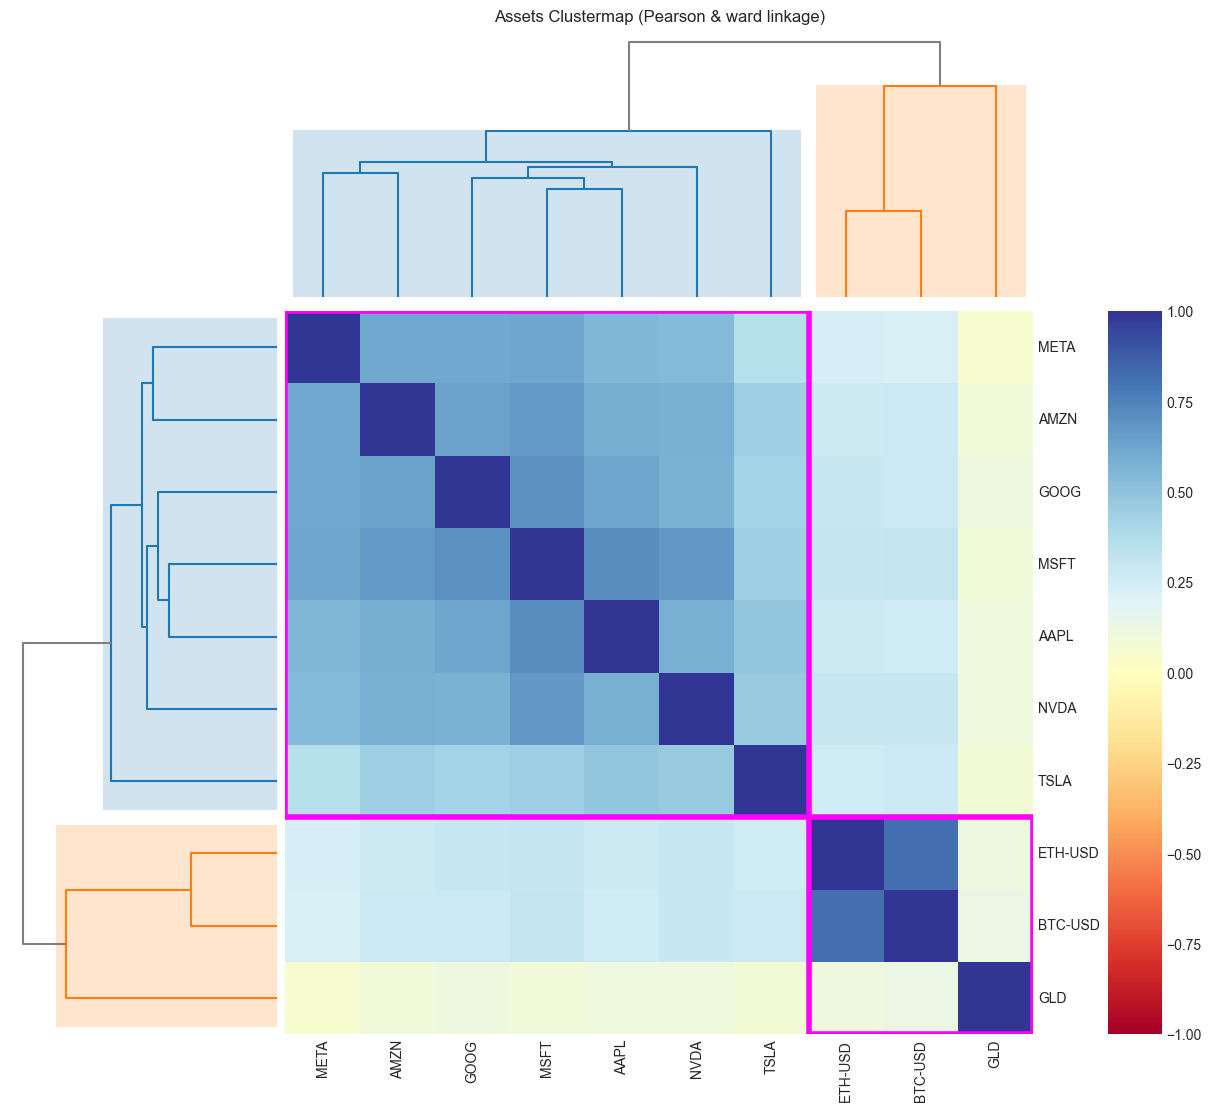

In [12]:
rp.plot_clusters(
    returns=returns,
    codependence="pearson",
    linkage="ward",
    k=None,
    max_k=10,
    leaf_order=True,
    ax=None
)

The clustering result reveals **two clear groups**:

- **Cluster 1 – Equities (AAPL, MSFT, AMZN, TSLA, NVDA, GOOG, META)**: These assets tend to move together, reflecting their shared exposure to equity market risk and, for many of them, to large-cap U.S. tech/ growth factors.
- **Cluster 2 – ETH, BTC, and GLD**: Despite their very different narratives (crypto vs. gold), these assets form a separate cluster, indicating that their day-to-day return patterns are meaningfully different from the equity group.

From a Dalio-style perspective, this is exactly what we are looking for: **distinct return streams** that are not all driven by the same underlying risk factors. In the next notebook, `PortfolioCreator`, we will build a **portfolio recommender** that:

- Focuses on a broader universe of **highly liquid assets**.
- Uses this kind of **correlation structure** to identify combinations of assets with more uncorrelated returns.
- Constructs portfolios inspired by Dalio's idea of improving risk-adjusted performance through diversification across genuinely different return streams.